# Facenet recreation
Google facenet recreation

In [2]:
!pip install torchinfo
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118
Using the GPU!


# Build Dataset from facenet
using instructions from pytorch docs: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
Reading pairs to ensure that muiltiple faces of a single person


In [3]:
# class LabledFacesWild(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         label_dict = []
#         with open(annotations_file) as f:
#             for line in f:
#                 print(line)
#                 name, i1, i2 = line.split('\t')
#                 label_dict.append({
#                     "label": name,
#                     "img1": f"{name}/{int(i1):04d}.jpg",
#                     "img2": f"{name}/{int(i2):04d}.jpg"
#                 })
#         self.img_labels = pd.DataFrame.from_records(label_dict)
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels) * 2

#     def __getitem__(self, idx):
#         pair_num = idx // 2
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[pair_num, (idx % 2) + 1])
#         image = read_image(img_path)
#         label = self.img_labels.iloc[pair_num, 0]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

# download msft zip files
!wget https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip
!wget https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_2000-3999_72_imgs.zip
!wget https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_4000-5999_72_imgs.zip
!wget https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_6000-7999_72_imgs.zip
!wget https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_8000-9999_72_imgs.zip

--2023-12-11 00:39:47--  https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_0-1999_72_imgs.zip
Resolving facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)... 20.38.109.4
Connecting to facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)|20.38.109.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2938553163 (2.7G) [application/octet-stream]
Saving to: ‘subjects_0-1999_72_imgs.zip’

subjects_0-1999_72_ 100%[===================>]   2.74G  12.5MB/s    in 3m 33s  

2023-12-11 00:43:20 (13.2 MB/s) - ‘subjects_0-1999_72_imgs.zip’ saved [2938553163/2938553163]

--2023-12-11 00:43:20--  https://facesyntheticspubwedata.blob.core.windows.net/wacv-2023/subjects_2000-3999_72_imgs.zip
Resolving facesyntheticspubwedata.blob.core.windows.net (facesyntheticspubwedata.blob.core.windows.net)... 20.38.109.4
Connecting to facesyntheticspubwedata.blob.core.windows.net (facesyn

In [4]:
# prompt: create commands to unzip datasets and put them all in one folder
!mkdir ./data
!unzip subjects_0-1999_72_imgs.zip -d ./data
!unzip subjects_2000-3999_72_imgs.zip -d ./data
!unzip subjects_4000-5999_72_imgs.zip -d ./data
!unzip subjects_6000-7999_72_imgs.zip -d ./data
!unzip subjects_8000-9999_72_imgs.zip -d ./data


Streaming output truncated to the last 5000 lines.
 extracting: ./data/9930/45.png      
 extracting: ./data/9930/46.png      
 extracting: ./data/9930/47.png      
 extracting: ./data/9930/48.png      
 extracting: ./data/9930/49.png      
 extracting: ./data/9930/5.png       
 extracting: ./data/9930/50.png      
 extracting: ./data/9930/51.png      
 extracting: ./data/9930/52.png      
 extracting: ./data/9930/53.png      
 extracting: ./data/9930/54.png      
 extracting: ./data/9930/55.png      
 extracting: ./data/9930/56.png      
 extracting: ./data/9930/57.png      
 extracting: ./data/9930/58.png      
 extracting: ./data/9930/59.png      
 extracting: ./data/9930/6.png       
 extracting: ./data/9930/60.png      
 extracting: ./data/9930/61.png      
 extracting: ./data/9930/62.png      
 extracting: ./data/9930/63.png      
 extracting: ./data/9930/64.png      
 extracting: ./data/9930/65.png      
 extracting: ./data/9930/66.png      
 extracting: ./data/9930/67.png      

In [5]:
class MSFT_Faces(Dataset):
    def __init__(self, img_dir, start_idx, end_idx, img_per_id, transform=None):
        self.start_idx = start_idx
        self.end_idx = end_idx
        self.img_per_id = img_per_id
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return self.end_idx - self.start_idx + 1

    def __getitem__(self, idx):
        person = idx + self.start_idx
        images = []
        for i in range(self.img_per_id):
            img_path = os.path.join(self.img_dir, f"{person}/{i}.png")
            image = torchvision.io.read_image(img_path)
            # remove alpha channel
            image = image[:3, :, :]
            image = image.float()
            if self.transform:
                image = self.transform(image)
            images.append(image)
        # create array of labels
        label = torch.tensor(np.full((self.img_per_id,), person)).float()
        return torch.stack(images), label

In [27]:
# actually load data

transform = transforms.Compose([
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# construct the dataloader
train_data = MSFT_Faces('./data/', 0, 3999, 20, transform)
test_data = MSFT_Faces('./data/', 8000, 9999, 20, transform)
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


# Create Facenet Model
Facenet model https://arxiv.org/pdf/1503.03832.pdf
Google Lenet 22layer: https://arxiv.org/pdf/1409.4842.pdf
input size = 250x250x3
use relu


In [28]:
class Facenet_NN1(nn.Module):
    def __init__(self):
        super().__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        # torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        # torch.nn.LocalResponseNorm(size, alpha=0.0001, beta=0.75, k=1.0)
        self.conv1 = nn.Conv2d(3, 64, 7,padding=3, stride=2)
        self.pool1 = nn.MaxPool2d(3, padding=1, stride=2)
        self.rnorm1 = nn.LocalResponseNorm(64)

        self.conv2a = nn.Conv2d(64, 64, 1, stride=1)
        self.conv2 = nn.Conv2d(64, 192, 3,padding=1, stride=1)
        self.rnorm2 = nn.LocalResponseNorm(192)
        self.pool2 = nn.MaxPool2d(3, padding=1, stride=2)

        self.conv3a = nn.Conv2d(192, 192, 1, stride=1)
        self.conv3 = nn.Conv2d(192, 384, 3, padding=1, stride=1)
        self.pool3 = nn.MaxPool2d(3, padding=1, stride=2)

        self.conv4a = nn.Conv2d(384, 384, 1, stride=1)
        self.conv4 = nn.Conv2d(384, 256, 3, padding=1, stride=1)

        self.conv5a = nn.Conv2d(256, 256, 1, stride=1)
        self.conv5 = nn.Conv2d(256, 256, 3,padding=1, stride=1)

        self.conv6a = nn.Conv2d(256, 256, 1, stride=1)
        self.conv6 = nn.Conv2d(256, 256, 3,padding=1, stride=1)
        self.pool4 = nn.MaxPool2d(3,padding=1, stride=2)

        #todo what is concat layer?
        self.fc1 = nn.Linear(256*4*4, 128*4*4)
        # self.maxout1 = nn.AdaptiveMaxPool2d((32,1))
        self.fc2 = nn.Linear(128 * 4 *4, 128 * 4)
        # self.maxout2 = nn.MaxPool2d(2)

        self.fc7128 = nn.Linear(128*4,128)




    def forward(self, x):
        batch_size = x.size(0)
        x1 = self.rnorm1(self.pool1(F.relu(self.conv1(x))))
        x2 = self.pool2(self.rnorm2(F.relu(self.conv2(self.conv2a(x1)))))
        x3 = self.pool3(F.relu(self.conv3(self.conv3a(x2))))
        x4 = F.relu(self.conv4(self.conv4a(x3)))
        x5 = F.relu(self.conv5(self.conv5a(x4)))
        x6 = self.pool4(F.relu(self.conv6(self.conv6a(x5))))
        x6i = torch.flatten(x6, 1)
        x7 = self.fc1(x6i)
        # x7i = torch.unflatten(x7, 1, (128, 7, 7))
        # x8 = self.maxout1(x7i)
        # x8i = torch.flatten(x8, 1)
        x9 = self.fc2(x7)
        # x9i = torch.unflatten(x9, 1, (128, 32))
        # x10 = self.maxout2(x9i)
        # x10i = torch.flatten(x10, 1)
        x11 = self.fc7128(x9)
        # normalize the output to a unit vector
        x11 = F.normalize(x11)

        #x7 = self.maxout2(self.fc2(self.maxout1(self.fc1(x6))))
        # ─Conv2d: 1-16                           [1, 256, 6, 6]            590,080
        # ─MaxPool2d: 1-17                        [1, 256, 2, 2]            --
        # return self.fc1(x6)
        return x11
        # return self.fc7128(x7)
        # return x5

In [ ]:
# # create inception module
# # https://www.kaggle.com/code/mohamedmustafa/10-implement-inceptionnet-from-scratch-pytorch
# class ConvBlock(nn.Module):
#     def __init__(self, In_Channels, Out_Channels, Kernel_Size, Stride, Padding):
#         super(ConvBlock, self).__init__()
#         self.Conv = nn.Conv2d(in_channels=In_Channels, out_channels=Out_Channels, kernel_size=Kernel_Size, stride=Stride, padding=Padding)
#         self.Batch_Norm = nn.BatchNorm2d(num_features=Out_Channels)
#         self.Activ_Func = nn.ReLU()

#     """
#     Now we'll build the forward function which defines the path to input tensor
#     meaning that we tell the tensor the sequence of layers you're going through
#     Takecare the name of forward function is sensitive so you have to name forward not any thing else
#     """
#     def forward(self, Tensor_Path):
#         Tensor_Path = self.Conv(Tensor_Path)
#         Tensor_Path = self.Batch_Norm(Tensor_Path)
#         Tensor_Path = self.Activ_Func(Tensor_Path)

#         return Tensor_Path

# class InceptionModule(nn.Module):
#     def __init__(self, num1x1, num3x3reduce, num3x3, num5x5reduce, num5x5, ) -> None:
#         super().__init__()


# # NN2
# class Facenet_NN2(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, x):
#         return x

In [23]:
# print summary
model = Facenet_NN1()
summary(model, input_size=(10, 3, 112, 112), verbose=2)

Layer (type:depth-idx)                   Output Shape              Param #
Facenet_NN1                              [10, 128]                 --
├─Conv2d: 1-1                            [10, 64, 56, 56]          9,472
│    └─weight                                                      ├─9,408
│    └─bias                                                        └─64
├─MaxPool2d: 1-2                         [10, 64, 28, 28]          --
├─LocalResponseNorm: 1-3                 [10, 64, 28, 28]          --
├─Conv2d: 1-4                            [10, 64, 28, 28]          4,160
│    └─weight                                                      ├─4,096
│    └─bias                                                        └─64
├─Conv2d: 1-5                            [10, 192, 28, 28]         110,784
│    └─weight                                                      ├─110,592
│    └─bias                                                        └─192
├─LocalResponseNorm: 1-6                 [10, 192,

Layer (type:depth-idx)                   Output Shape              Param #
Facenet_NN1                              [10, 128]                 --
├─Conv2d: 1-1                            [10, 64, 56, 56]          9,472
│    └─weight                                                      ├─9,408
│    └─bias                                                        └─64
├─MaxPool2d: 1-2                         [10, 64, 28, 28]          --
├─LocalResponseNorm: 1-3                 [10, 64, 28, 28]          --
├─Conv2d: 1-4                            [10, 64, 28, 28]          4,160
│    └─weight                                                      ├─4,096
│    └─bias                                                        └─64
├─Conv2d: 1-5                            [10, 192, 28, 28]         110,784
│    └─weight                                                      ├─110,592
│    └─bias                                                        └─192
├─LocalResponseNorm: 1-6                 [10, 192,

# Train Facenet Model
training data
In all our experiments we train the CNN using Stochastic
Gradient Descent (SGD) with standard backprop [8, 11] and
AdaGrad [5]. In most experiments we start with a learning
rate of 0.05 which we lower to finalize the model. The models are initialized from random, similar to [16], and trained
on a CPU cluster for 1,000 to 2,000 hours. The decrease in
the loss (and increase in accuracy) slows down drastically
after 500h of training, but additional training can still significantly improve performance. The margin α is set to 0.2.

In [30]:
# online triplet selection
# https://github.com/adambielski/siamese-triplet
# https://github.com/adambielski/siamese-triplet/blob/master/utils.py

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None


def get_triplets( embeddings, labels, margin, negative_selection_fn):
        embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(itertools.combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = negative_selection_fn(loss_values, margin)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


In [35]:
# create triplett loss object
triplet_loss = nn.TripletMarginLoss(margin=0.2, p=2)

margin = 0.2
def train(NN, num_epochs = 50):
  hist_train_losses = []
  ###########################################################################
  # Add  adagrad optimizer              #
  # lr = 0.05                 #
  ###########################################################################
  optimizer = optim.Adagrad(NN.parameters(), lr=0.05, lr_decay=0.001)
  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  print('training start!')
  start_time = time.time()
  for epoch in range(num_epochs):
    print('Start training epoch %d' % (epoch + 1))
    epoch_losses=[]
    epoch_start_time = time.time()
    num_iter = 0
    for images, labels in train_loader:
      # print(images.shape)
      # print(labels.shape)

      # colapse the first two dimensions
      images = images.view(-1, 3, 112, 112)
      labels = labels.view(-1)
      # convert to float
      images = images.to(device)
      labels = labels.to(device)
      # print(images.shape)
      # print(labels.shape)

      ###########################################################################
      # TODO: Implement training code for the discriminator.                    #
      # Recall that the loss is the mean of the loss for real images and fake   #
      # images, and made by some calculations with zeros and ones               #
      # We have defined the BCE_loss, which you might would like to use         #
      ###########################################################################
      NN.zero_grad()

      # get embeddings
      embeddings = NN(images)

      # get triplets
      triplets = get_triplets(embeddings, labels, margin, semihard_negative)
      anchor = embeddings[triplets[:, 0]]
      positive = embeddings[triplets[:, 1]]
      negative = embeddings[triplets[:, 2]]


      # get triplet loss
      loss = triplet_loss(anchor, positive, negative)

      # backpropagate
      loss.backward()
      optimizer.step()

      loss_e = loss.detach().item()
      ###########################################################################
      #                              END OF YOUR CODE                           #
      ###########################################################################

      epoch_losses.append(loss_e)
      num_iter += 1

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss for epoch: %.3f' % (torch.mean(torch.FloatTensor(epoch_losses))))
    hist_train_losses.append(torch.mean(torch.FloatTensor(epoch_losses)))

    # save model
    if epoch == 0 or (epoch + 1) % 5 == 0:
      with torch.no_grad():
        # save model parameters
        torch.save(NN.state_dict(), 'model_epoch_%d.pth' % (epoch + 1))

  end_time = time.time()
  total_ptime = end_time - start_time
  print(total_ptime)
  return NN, hist_train_losses

training start!
Start training epoch 1
[1/50] - using time: 289.40 seconds
loss for epoch: 0.129
Start training epoch 2
[2/50] - using time: 260.06 seconds
loss for epoch: 0.126
Start training epoch 3
[3/50] - using time: 258.99 seconds
loss for epoch: 0.113
Start training epoch 4
[4/50] - using time: 257.20 seconds
loss for epoch: 0.109
Start training epoch 5
[5/50] - using time: 258.11 seconds
loss for epoch: 0.108
Start training epoch 6
[6/50] - using time: 256.58 seconds
loss for epoch: 0.107
Start training epoch 7
[7/50] - using time: 257.22 seconds
loss for epoch: 0.106
Start training epoch 8
[8/50] - using time: 257.70 seconds
loss for epoch: 0.106
Start training epoch 9
[9/50] - using time: 258.40 seconds
loss for epoch: 0.105
Start training epoch 10
[10/50] - using time: 256.34 seconds
loss for epoch: 0.105
Start training epoch 11
[11/50] - using time: 257.41 seconds
loss for epoch: 0.104
Start training epoch 12
[12/50] - using time: 256.65 seconds
loss for epoch: 0.104
Start 

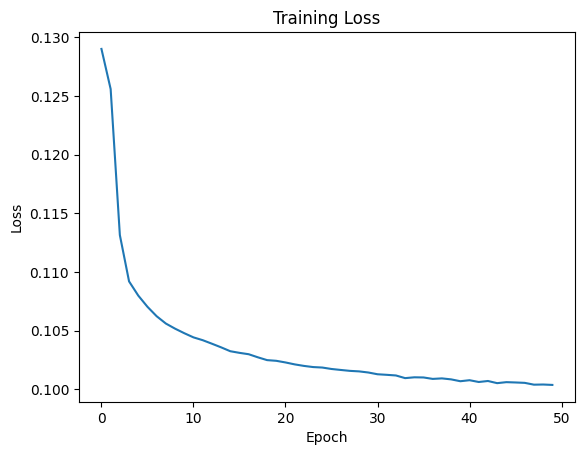

In [36]:
# Define network
NN1 = Facenet_NN1()
NN1.to(device)
NN1.train()

# training
NN, hist_losses = train(NN1, 50)

# save model
torch.save(NN.state_dict(), 'model_final.pth')

# plot losses
plt.plot(hist_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Test Facenet Model
See Matching.py